# Post-processing
In this section, we discuss how to access and work with data from optimization records.
This includes loading various data, visualizing results, and hot-starting an optimization 
using optimization records.

## Recording an optimization
We start by recording an optimization, as discussed in the [previous section](./optimization.ipynb).
The problem is the same as before, and we use the `TrustConstr` optimizer.

In [ ]:
import numpy as np
import modopt as mo

x0 = np.array([50., 5.])            # initial guess
xl = np.array([0., -np.inf])        # variable lower bounds
cl = np.array([1., 1.])             # constraint lower bounds
cu = np.array([1., np.inf])         # constraint upper bounds
c_scaler = np.array([10., 100.])    # constraint scaler

def obj(x):
    return np.sum(x**2)
def grad(x):    
    return 2 * x
def con(x):
    return np.array([x[0] + x[1], x[0] - x[1]])
def jac(x):
    return np.array([[1., 1], [1., -1]])

# Define the problem as a ProblemLite object 
# A ProblemLite object acts as a container for the problem constants, functions, and their derivatives
problem = mo.ProblemLite(
    x0, 
    obj=obj, 
    grad=grad, 
    con=con, 
    jac=jac, 
    cl=cl, 
    cu=cu,
    xl=xl,
    c_scaler = c_scaler,
    name='constrained_quadratic'
    )

optimizer = mo.TrustConstr(problem=problem, 
                           solver_options={'maxiter': 100, 'gtol': 1e-12},
                           recording=True)
results   = optimizer.solve()
optimizer.print_results()

# Print the directory and its contents to see the generated output files
print('Output Directory:', optimizer.out_dir)
print('Output Files:', optimizer.modopt_output_files)


	Solution from Scipy trust-constr:
	----------------------------------------------------------------------------------------------------
	Problem                       : constrained_quadratic
	Solver                        : scipy-trust-constr
	Method                        : tr_interior_point
	Success                       : True
	Message                       : `gtol` termination condition is satisfied.
	Status                        : 1
	Total time                    : 0.14261221885681152
	Objective                     : 1.0000320268995626
	Gradient norm                 : 2.000032026643136
	Optimality                    : 4.3125588820511207e-13
	Max. constr. violation        : 0.0
	Trust region radius           : 639535.7360242795
	Constraint penalty            : 1.0
	Barrier parameter             : 3.200000000000001e-05
	Barrier tolerance             : 3.200000000000001e-05
	Total function evals          : 13
	Total gradient evals          : 13
	Total Hessian evals           : 0
	

## Viewing record contents

To view the data available in a record, call the `print_record_contents()` utility with the record file name,
as shown below.
There are four types of information available in a record: `attributes`, `opt_vars`, `callback_vars`, and `results`.
The `print_record_contents()` function always returns a tuple containing four lists, one for each type of information.
To suppress printing, set the keyword argument `suppress_print=True`.

In [5]:
from modopt.postprocessing import print_record_contents
record_contents = print_record_contents(optimizer.out_dir+'/record.hdf5')

Available data in the record:
-----------------------------
 - Attributes of optimization    : ['c_lower', 'c_scaler', 'c_upper', 'constrained', 'hot_start_from', 'modopt_output_files', 'nc', 'nx', 'o_scaler', 'problem_name', 'readable_outputs', 'recording', 'solver_name', 'solver_options-barrier_tol', 'solver_options-callback', 'solver_options-factorization_method', 'solver_options-gtol', 'solver_options-ignore_exact_hessian', 'solver_options-initial_barrier_parameter', 'solver_options-initial_barrier_tolerance', 'solver_options-initial_constr_penalty', 'solver_options-initial_tr_radius', 'solver_options-maxiter', 'solver_options-sparse_jacobian', 'solver_options-verbose', 'solver_options-xtol', 'timestamp', 'visualize', 'x0', 'x_lower', 'x_scaler', 'x_upper']
 - Recorded optimizer variables  : ['barrier_parameter', 'barrier_tolerance', 'cg_niter', 'cg_stop_cond', 'con', 'constr_penalty', 'feas', 'grad', 'iter', 'jac', 'lgrad', 'lmult_c', 'lmult_x', 'ncev', 'ncgev', 'nchev', 'nfev', '

## Loading results and attributes

Attributes and results of an optimization can be loaded as dictionaries 
by calling the `load_attributes()` and `load_results()` utility functions 
with the record file name, as shown below.

In [7]:
from modopt.postprocessing import load_attributes, load_results
attributes = load_attributes(optimizer.out_dir+'/record.hdf5')
results    = load_results(optimizer.out_dir+'/record.hdf5')

print("Attributes:")
print(attributes)

print("Results:")
print(results)

Attributes:
{'c_lower': array([1., 1.]), 'c_scaler': array([ 10., 100.]), 'c_upper': array([ 1., inf]), 'constrained': True, 'hot_start_from': 'None', 'modopt_output_files': ['directory: constrained_quadratic_outputs/2025-02-03_12.25.55.893290', 'modopt_results.out', 'modopt_summary.out', 'record.hdf5'], 'nc': 2, 'nx': 2, 'o_scaler': array([1.]), 'problem_name': 'constrained_quadratic', 'readable_outputs': [], 'recording': 'True', 'solver_name': 'scipy-trust-constr', 'solver_options-barrier_tol': 1e-08, 'solver_options-callback': 'None', 'solver_options-factorization_method': 'None', 'solver_options-gtol': 1e-12, 'solver_options-ignore_exact_hessian': False, 'solver_options-initial_barrier_parameter': 0.1, 'solver_options-initial_barrier_tolerance': 0.1, 'solver_options-initial_constr_penalty': 1.0, 'solver_options-initial_tr_radius': 1.0, 'solver_options-maxiter': 100, 'solver_options-sparse_jacobian': 'None', 'solver_options-verbose': 0, 'solver_options-xtol': 1e-08, 'timestamp': '20

## Loading variable iterates

The `load_variables()` utility function loads variable iterates from the record.
This function requires two arguments: 1) the record file name, and 2) the list of variable names to load. 
The function returns a dictionary with *keys* as variable names and *values* as lists of variable iterates 
corresponding to those variable names.
Note that the keys for **callback_variables** will be prefixed with `'callback_'`.
If only specific scalar variables need to be loaded from an array variable, use the format `'var_name[idx]'`.
For example,
- `'x[0]'` will load the iterates for the first element of the array 'x', and
- `'jac[i,j]'` will load the iterates for the (i,j)-th element of the array 'jac'.

The `load_variables()` function also provides an optional keyword argument, `callback_context`,
to load **callback_variables** together with its corresponding inputs. 
To learn more about `callback_context`, visit the [API Reference](./api/postprocessing.md).

The following code loads the iterates of x[0], the objective, the Jacobian, optimality, and feasibility
from the record.

In [24]:
from modopt.postprocessing import load_variables
vars = load_variables(optimizer.out_dir+'/record.hdf5', ['x[0]', 'obj', 'jac', 'opt', 'feas'])

print('Loaded variables:')
print(vars.keys())

# Print the loaded variable iterates
for key, value in vars.items():
    print('\n', key, ':')
    print(value)

Loaded variables:
dict_keys(['x[0]', 'callback_x[0]', 'obj', 'callback_obj', 'jac', 'callback_jac', 'opt', 'feas'])

 x[0] :
[50.0, 49.06680741392834, 42.1402716614226, 13.137131926669479, 3.265462548872426, 1.426337395295874, 1.1484153222707345, 1.0661629237127606, 1.0661629237127606, 1.0170864850904997, 1.0170864850904997, 1.0026442417982402, 1.0026442417982402, 1.0004156095347128, 1.0004156095347128, 1.0000803575038417, 1.0000803575038417, 1.0000160131933589]

 callback_x[0] :
[50.0, 50.0, 50.0, 50.0, 49.06680741392834, 49.06680741392834, 49.06680741392834, 49.06680741392834, 42.1402716614226, 42.1402716614226, 42.1402716614226, 42.1402716614226, 13.137131926669479, 13.137131926669479, 13.137131926669479, 13.137131926669479, 3.265462548872426, 3.265462548872426, 3.265462548872426, 3.265462548872426, 1.426337395295874, 1.426337395295874, 1.426337395295874, 1.426337395295874, 1.1484153222707345, 1.1484153222707345, 1.1484153222707345, 1.1484153222707345, 1.0661629237127606, 1.06616292

## Visualizing recorded optimization
A recorded optimization can be visualized using the `visualize()` function from the post-processing utilities.
This function plots scalar variables after loading them from the record.
The two required arguments are: 1) the record file name, and 2) the list of variable names to visualize. 
The final optimization plot can be saved to a file by setting the keyword argument `save_figname`,
which is `None` by default.

The following code plots the iterations of x[0], the objective, the Jacobian, optimality, and feasibility
from the record and saves them to a file named *'post_opt_viz.pdf'*.

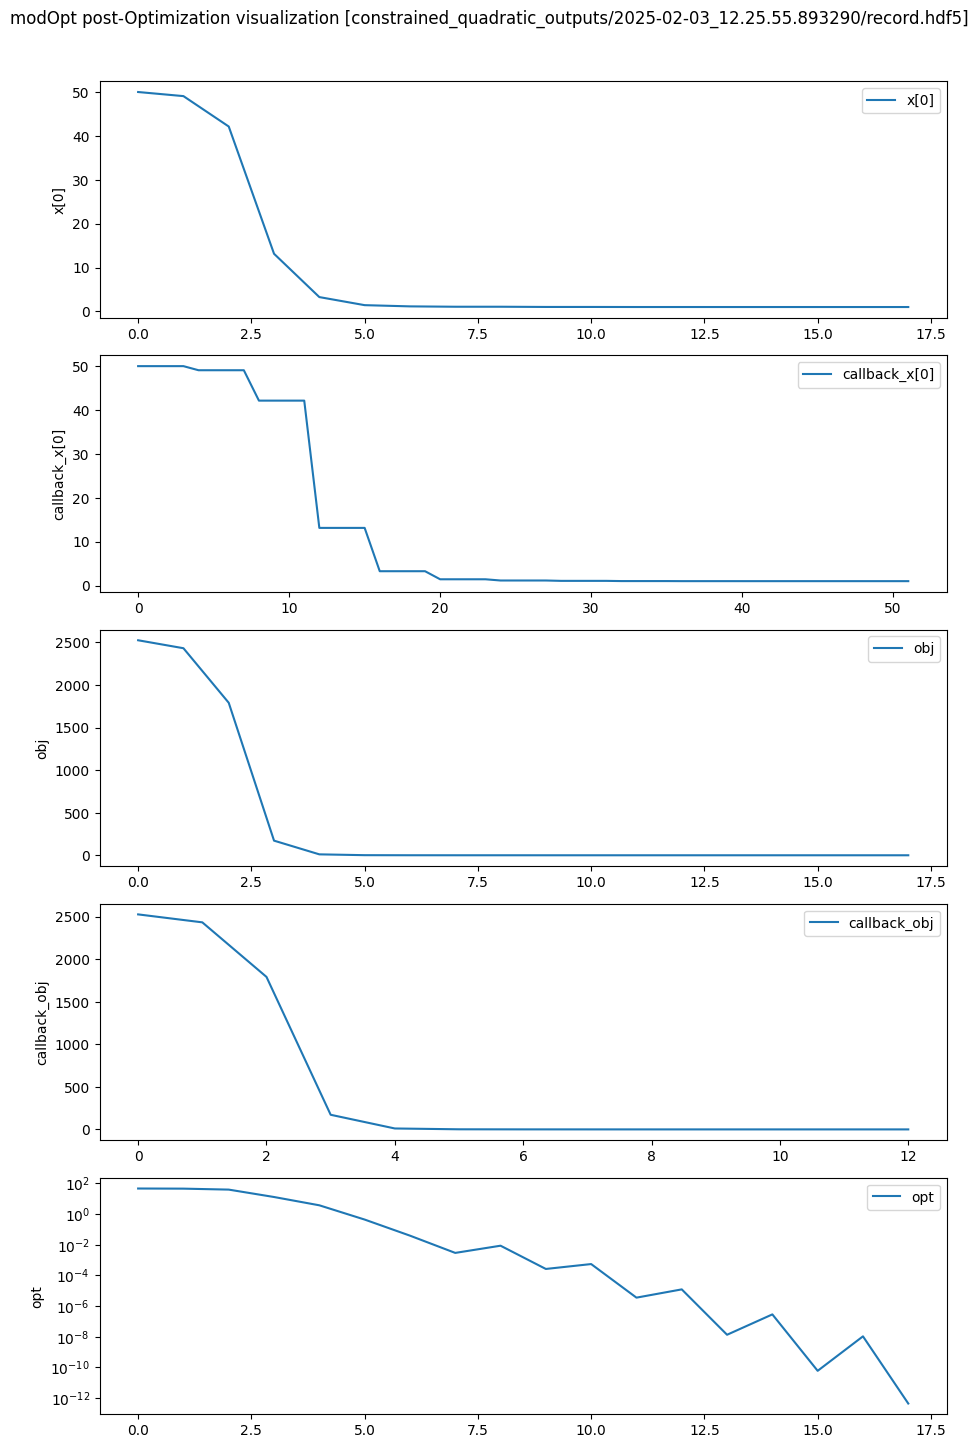

In [28]:
%matplotlib inline

from modopt.postprocessing import visualize
visualize(optimizer.out_dir+'/record.hdf5', ['x[0]', 'obj', 'opt', 'feas', 'jac[0,0]'], save_figname='post_opt_viz.pdf')

## Restarting optimization: Hot-starts leveraging previous records

In practical situations, users may need to rerun a previously completed optimization 
if it terminates before reaching a sufficiently optimal solution.
For instance, this may occur when an algorithm exits due to reaching the iteration limit or
loosely set convergence tolerances.
In such cases, the optimization must be re-executed with a higher iteration limit
or tighter tolerances to achieve the desired results.
When the problem functions and/or their derivatives are costly to evaluate,
even a few reruns can significantly increase the overall optimization time, 
making it highly inefficient.
The hot-starting feature in modOpt utilizes the record file from a prior optimization 
to efficiently reuse previously computed function and derivative values, thereby
avoiding unnecessary computational costs.

One key benefit of hot-starting, as opposed to simply restarting from the previous solution, is
that quasi-Newton methods maintain the same Hessian approximations from the prior run during
a hot-start.
In contrast, normal restarting initializes the approximate Hessian as an identity matrix, 
potentially increasing the number of additional iterations required for convergence, 
even if we start from the previous solution.
Furthermore, restarting resets the Lagrange multipliers, which may also necessitate additional iterations, 
as the convergence of optimization variables often follows the convergence of Lagrange multipliers.

To hot-start a problem, set the `hot_start_from` parameter when instantiating the optimizer object. 
The `hot_start_from` parameter specifies the record from which 
the data should be reused when rerunning an optimization.
Users can also set `hot_start_atol` and `hot_start_rtol`, 
which define the absolute and relative tolerances for the inputs 
when reusing outputs from the hot-start record.
These tolerances are particularly useful in distributed computing environments 
where computations are performed across multiple processors or GPUs, 
as numerical discrepancies may arise due to variations in floating-point arithmetic and parallel execution.
Both tolerances are set to zero by default.
<!-- These tolerances are particularly useful in situations 
where computations are distributed over multiple processors or GPUs,
leading to outputs that are not always exact up to machine precision. -->

The following code hot-starts the same problem we solved and recorded at the beginning of this page
but with a tighter tolerance.

In [29]:
hot_start_record = optimizer.out_dir+'/record.hdf5'
optimizer = mo.TrustConstr(problem=problem, 
                           solver_options={'maxiter': 100, 'gtol': 1e-14},
                           hot_start_from= hot_start_record)
results   = optimizer.solve()
optimizer.print_results()


	Solution from Scipy trust-constr:
	----------------------------------------------------------------------------------------------------
	Problem                       : constrained_quadratic
	Solver                        : scipy-trust-constr
	Method                        : tr_interior_point
	Success                       : True
	Message                       : `gtol` termination condition is satisfied.
	Status                        : 1
	Total time                    : 0.21609711647033691
	Objective                     : 1.0000064010669836
	Gradient norm                 : 2.00000640105674
	Optimality                    : 3.5429931286978106e-15
	Max. constr. violation        : 1.7763568394002505e-15
	Trust region radius           : 3197678.6801213976
	Constraint penalty            : 1.0
	Barrier parameter             : 6.400000000000003e-06
	Barrier tolerance             : 6.400000000000003e-06
	Total function evals          : 14
	Total gradient evals          : 14
	Total Hessian ev

/Users/venv/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


From the console output above, we see that out of the 56 callbacks made by the optimizer, 
52 were reused from the previous record and were never recomputed using the user-provided functions.
Only one new evaluation of the objective, gradient, constraint, and Jacobian was performed 
to achieve a more optimal solution necessitated by the tighter tolerance.

For more details on any of the post-processing utilities, 
visit the [API Reference](./api/postprocessing.md) page.